<a href="https://colab.research.google.com/github/Navanithapatel/GEN-AI-workshop/blob/main/BaBIQA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import os
import numpy as np
import tensorflow as tf
import kagglehub

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Dense, LayerNormalization,
    MultiHeadAttention, GlobalAveragePooling1D,
    Concatenate, Embedding
)
from tensorflow.keras.models import Model


In [12]:
path = kagglehub.dataset_download(
    "roblexnana/the-babi-tasks-for-nlp-qa-system"
)
print("Dataset downloaded at:", path)


Using Colab cache for faster access to the 'the-babi-tasks-for-nlp-qa-system' dataset.
Dataset downloaded at: /kaggle/input/the-babi-tasks-for-nlp-qa-system


In [13]:
def find_file(base_path, filename):
    for root, _, files in os.walk(base_path):
        if filename in files:
            return os.path.join(root, filename)
    raise FileNotFoundError(filename)

train_file = find_file(path, "qa1_single-supporting-fact_train.txt")
test_file  = find_file(path, "qa1_single-supporting-fact_test.txt")


In [14]:
def parse_babi(file_path):
    stories, questions, answers = [], [], []
    story = []

    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            nid, text = line.split(" ", 1)

            if nid == "1":
                story = []

            if "\t" in text:
                q, a, _ = text.split("\t")
                stories.append(" ".join(story))
                questions.append(q)
                answers.append(a)
            else:
                story.append(text)

    return stories, questions, answers


In [15]:
train_stories, train_questions, train_answers = parse_babi(train_file)
test_stories, test_questions, test_answers = parse_babi(test_file)

print("Training samples:", len(train_stories))


Training samples: 10000


In [16]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(
    train_stories + train_questions + train_answers
)

vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary size:", vocab_size)

max_story_len = max(len(s.split()) for s in train_stories)
max_question_len = max(len(q.split()) for q in train_questions)


Vocabulary size: 20


In [17]:
def vectorize(stories, questions, answers):
    s = tokenizer.texts_to_sequences(stories)
    q = tokenizer.texts_to_sequences(questions)
    a = tokenizer.texts_to_sequences(answers)

    s = pad_sequences(s, maxlen=max_story_len)
    q = pad_sequences(q, maxlen=max_question_len)

    a = np.array([x[0] for x in a])

    return s, q, a


In [18]:
x_story, x_question, y = vectorize(
    train_stories, train_questions, train_answers
)

x_story_test, x_question_test, y_test = vectorize(
    test_stories, test_questions, test_answers
)


In [19]:
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, max_len, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = Embedding(vocab_size, embed_dim)
        self.pos_emb = Embedding(max_len, embed_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=tf.shape(x)[1])
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions


In [22]:
def transformer_encoder(x, embed_dim, num_heads, ff_dim):
    attn = MultiHeadAttention(
        num_heads=num_heads,
        key_dim=embed_dim
    )(x, x)

    x = LayerNormalization(epsilon=1e-6)(x + attn)

    ffn = Dense(ff_dim, activation="relu")(x)
    ffn = Dense(embed_dim)(ffn)

    return LayerNormalization(epsilon=1e-6)(x + ffn)


In [23]:
embed_dim = 64

story_input = Input(shape=(max_story_len,))
question_input = Input(shape=(max_question_len,))

story_embed = PositionalEmbedding(
    max_story_len, vocab_size, embed_dim
)(story_input)

question_embed = PositionalEmbedding(
    max_question_len, vocab_size, embed_dim
)(question_input)

story_encoded = transformer_encoder(
    story_embed, embed_dim=embed_dim, num_heads=2, ff_dim=128
)

question_encoded = transformer_encoder(
    question_embed, embed_dim=embed_dim, num_heads=2, ff_dim=128
)

qa_attention = MultiHeadAttention(
    num_heads=2, key_dim=embed_dim
)(
    query=question_encoded,
    key=story_encoded,
    value=story_encoded
)

story_vec = GlobalAveragePooling1D()(qa_attention)
question_vec = GlobalAveragePooling1D()(question_encoded)

merged = Concatenate()([story_vec, question_vec])

output = Dense(vocab_size, activation="softmax")(merged)

model = Model(
    inputs=[story_input, question_input],
    outputs=output
)




In [24]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)


In [25]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 58)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_3       │ (None, 3)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 58, 64)    │      4,992 │ input_layer_2[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, 3, 64)     │      1,472 │ input_layer_3[0]… │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 58, 64)    │     33,216 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 3, 64)     │     33,216 │ positional_embed… │
│ (MultiHeadAttentio… │                   │            │ positional_embed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 58, 64)    │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 3, 64)     │          0 │ positional_embed… │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 58, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 64)     │        128 │ add_4[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 58, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 3, 128)    │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 58, 64)    │      8,256 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 3, 64)     │      8,256 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 58, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_5 (Add)         │ (None, 3, 64)     │          0 │ layer_normalizat… │
│                     │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 58, 64)    │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 3, 64)     │        128 │ add_5[0][0]       │
│ (LayerNormalizatio… │                   │            │                 

 Total params: 142,356 (556.08 KB)

 Trainable params: 142,356 (556.08 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
history = model.fit(
    [x_story, x_question],
    y,
    batch_size=32,
    epochs=30,
    validation_split=0.1
)


Epoch 1/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 28s 68ms/step - accuracy: 0.3443 - loss: 1.6703 - val_accuracy: 0.5020 - val_loss: 1.2026
Epoch 2/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 63ms/step - accuracy: 0.5076 - loss: 1.1241 - val_accuracy: 0.4940 - val_loss: 1.1249
Epoch 3/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.5252 - loss: 1.0766 - val_accuracy: 0.5210 - val_loss: 1.0773
Epoch 4/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 22s 64ms/step - accuracy: 0.5144 - loss: 1.0727 - val_accuracy: 0.5190 - val_loss: 1.1021
Epoch 5/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.5253 - loss: 1.0660 - val_accuracy: 0.5400 - val_loss: 1.0713
Epoch 6/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.5185 - loss: 1.0456 - val_accuracy: 0.5050 - val_loss: 1.0948
Epoch 7/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 20s 72ms/step - accuracy: 0.5210 - loss: 1.0507 - val_accuracy: 0.5300 - val_loss: 1.0650
Epoch 8/30
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 60ms/step - accuracy: 0.5171 - loss: 1.0442 - 

In [28]:
loss, acc = model.evaluate(
    [x_story_test, x_question_test],
    y_test
)

print("Transformer QA Test Accuracy:", acc)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5080 - loss: 1.0963
Transformer QA Test Accuracy: 0.4830000102519989


In [29]:
def predict_answer(story, question):
    s = tokenizer.texts_to_sequences([story])
    q = tokenizer.texts_to_sequences([question])

    s = pad_sequences(s, maxlen=max_story_len)
    q = pad_sequences(q, maxlen=max_question_len)

    pred = model.predict([s, q])
    answer_index = np.argmax(pred)

    for word, idx in tokenizer.word_index.items():
        if idx == answer_index:
            return word

# Example
print(predict_answer(
    "Mary went to the kitchen. John moved to the garden.",
    "Where is Mary?"
))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step
rtxahm


In [30]:
model.save("transformer_babi_qa_model.h5")


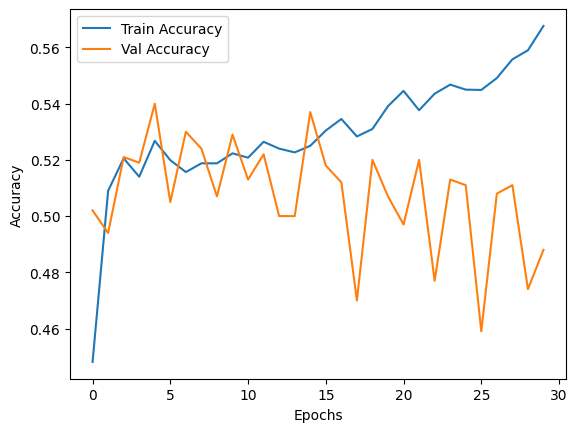

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.show()
